## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_squared_error
from math import sqrt
import glob
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from tensorflow import keras

## Spatial utility functions

In [2]:
# Returns 2D grid location of a SquareId value
# Note: Returns (row, col) NOT (x,y)
def get_grid_location(grid_id):
    
    num_rows = 100
    num_cols = 100
    grid_index = grid_id - 1 #grid id is not 0-indexed
    row_loc = num_rows - 1 - grid_index // num_rows
    col_loc = grid_index % num_rows
    
    return row_loc, col_loc

#get_grid_location(9999)

In [3]:
# Returns index value of grid based on (row, col) numbers specified
def get_grid_id(row_loc, col_loc):
    
    num_rows = 100
    num_cols = 100
    return (num_rows - row_loc - 1)*100 + col_loc + 1
    
#get_grid_id(0,98)

In [4]:
# Return a list of grid index values based on a radius (default 1) around center index value
def get_neighbours(grid_id, radius=1):
    grid_row, grid_col = get_grid_location(grid_id)
    neighbours = []
    for row in range(-radius+grid_row, radius+1+grid_row):
        for col in range(-radius+grid_col, radius+1+grid_col):
            val = get_grid_id(row, col)
            if val > 0 and val < 10001:
                neighbours.append(get_grid_id(row,col))
    
    return neighbours

In [5]:
#print(get_neighbours(9899,2))

## Reading data from pickle

In [6]:
df_big = pd.read_pickle("../data_pickles/all.pkl")
print(df_big.shape)
df_big.head(20)

(160681352, 3)


,SquareId,TimeInterval,InternetActivity
0,1,1383260400000,11.028366
1,1,1383261000000,0.026137
2,1,1383261000000,11.100963
3,1,1383261600000,10.892771
4,1,1383262200000,8.622425
5,1,1383262800000,8.009927
6,1,1383263400000,8.118420
7,1,1383264000000,8.026270
8,1,1383264600000,8.514179
9,1,1383265200000,6.833425


## Preprocess Data

In [7]:
# ----EXPERIMENT VARIABLES------------------------------------------------------------
grid_main = get_grid_id(70,10)
# Determine how many values to choose
num_values = 81
# -----------------------------------------------------------------------------------

# To make computation easier, the correlation will only be considered from a 20 radius around the center 
radius = 20
grid_neighbours = get_neighbours(grid_main, radius)

df = df_big[df_big['SquareId'].isin(grid_neighbours)]
#print(grid_neighbours)

In [8]:
df = df.set_index('TimeInterval')
df.index = pd.to_datetime(df.index, unit='ms')

In [9]:
df = df.dropna()
df = df.groupby([df.index, 'SquareId']).sum()

In [10]:
df.head(20)

InternetActivity
TimeInterval        SquareId                  
2013-10-31 23:00:00 891               1.378917
                    892               1.302653
                    893               2.483885
                    894               4.260547
                    895               5.323347
                    896               6.192155
                    897              18.130815
                    898              20.777678
                    899              15.240096
                    900               8.926782
                    901               3.678985
                    902               3.678985
                    903               3.686005
                    904               3.719332
                    905               3.712465
                    906               3.796835
                    907               3.889066
                    908               3.743944
                    909               3.389205
                    910               3.391592

In [11]:
df.index

MultiIndex([('2013-10-31 23:00:00',  891),
            ('2013-10-31 23:00:00',  892),
            ('2013-10-31 23:00:00',  893),
            ('2013-10-31 23:00:00',  894),
            ('2013-10-31 23:00:00',  895),
            ('2013-10-31 23:00:00',  896),
            ('2013-10-31 23:00:00',  897),
            ('2013-10-31 23:00:00',  898),
            ('2013-10-31 23:00:00',  899),
            ('2013-10-31 23:00:00',  900),
            ...
            ('2014-01-01 22:50:00', 4922),
            ('2014-01-01 22:50:00', 4923),
            ('2014-01-01 22:50:00', 4924),
            ('2014-01-01 22:50:00', 4925),
            ('2014-01-01 22:50:00', 4926),
            ('2014-01-01 22:50:00', 4927),
            ('2014-01-01 22:50:00', 4928),
            ('2014-01-01 22:50:00', 4929),
            ('2014-01-01 22:50:00', 4930),
            ('2014-01-01 22:50:00', 4931)],
           names=['TimeInterval', 'SquareId'], length=15007968)

In [12]:
df = df.unstack(level=-1).InternetActivity.rename_axis([None], axis=1)

In [13]:
# Will have to monitor this to make sure it's not too invasive. Otherwise, change to moving average or drop entirely
df = df.fillna(0)

In [14]:
print(df.shape)
df.head()

(8928, 1681)


,891,892,893,894,895,896,897,898,899,900,...,4922,4923,4924,4925,4926,4927,4928,4929,4930,4931
TimeInterval,,,,,,,,,,,,,,,,,,,,,
2013-10-31 23:00:00,1.378917,1.302653,2.483885,4.260547,5.323347,6.192155,18.130815,20.777678,15.240096,8.926782,...,35.026677,25.834836,25.743762,28.511631,274.173588,242.886336,80.231104,84.073422,85.936558,71.408453
2013-10-31 23:10:00,1.261744,1.184689,2.509369,4.336857,5.317577,5.251785,9.157441,9.996380,7.558499,5.268968,...,28.412837,26.368417,26.277268,28.464777,256.451007,228.958441,81.257954,79.614565,81.357309,61.113235
2013-10-31 23:20:00,1.224286,1.105945,2.345042,4.061801,5.214940,6.074995,9.302660,9.667080,7.361133,5.907693,...,27.947489,27.902658,27.947100,30.066475,278.053999,248.409643,85.431000,80.665829,81.476346,69.801568
2013-10-31 23:30:00,1.590738,1.506024,3.281853,5.526577,6.865686,7.354481,9.968912,10.286532,8.277171,7.152919,...,39.124801,53.377594,53.701365,55.445799,282.264327,248.465238,72.665560,76.567067,79.876016,66.082580
2013-10-31 23:40:00,0.672149,0.612031,2.013020,4.011041,4.800545,4.369967,8.285187,9.338140,7.892885,6.533867,...,33.885952,27.661296,27.614184,28.985915,271.649246,238.520014,64.141634,67.337802,70.173525,55.016933


In [15]:
df_corr = df.corr()

In [16]:
df_corr.sort_values(by=grid_main, ascending=False)[grid_main]

2911    1.000000
3312    0.995783
3309    0.994841
3209    0.994839
3308    0.994839
          ...   
2631    0.050094
3022    0.046764
3021    0.016959
3318    0.002407
3418    0.002407
Name: 2911, Length: 1681, dtype: float64

In [17]:

corr_ids = df_corr.sort_values(by=grid_main, ascending=False).index.values[:num_values].tolist()

In [18]:
df = df[corr_ids]

In [19]:
df.head()

,2911,3312,3309,3209,3308,3210,3208,3107,3011,3010,...,2324,1628,4091,2523,2628,2426,1825,2693,2527,1728
TimeInterval,,,,,,,,,,,,,,,,,,,,,
2013-10-31 23:00:00,8.058796,5.505912,8.122294,8.118974,8.118974,8.118974,8.118974,8.118974,8.118974,8.118974,...,3.189967,2.110248,15.784325,6.241211,2.072132,2.214512,4.907974,22.311629,1.910615,2.806771
2013-10-31 23:10:00,6.763432,4.476441,6.707130,6.702997,6.702997,6.702997,6.702997,6.702997,6.702997,6.702997,...,3.170075,2.281090,15.814203,6.583567,2.174806,2.303531,5.163066,23.669574,2.064169,3.032808
2013-10-31 23:20:00,11.588359,7.802069,11.981961,11.978180,11.978180,11.978180,11.978180,11.978180,11.978180,11.978180,...,3.255940,1.658597,15.860535,7.142829,1.764066,2.049491,4.491226,23.225556,1.611854,2.310801
2013-10-31 23:30:00,7.026344,4.695233,6.865032,6.861932,6.861932,6.861932,6.861932,6.861932,6.861932,6.861932,...,3.056633,2.527165,15.128586,6.409866,1.802503,2.165873,5.242354,23.589437,1.747989,3.558468
2013-10-31 23:40:00,5.908692,3.491140,5.088225,5.084863,5.084863,5.084863,5.084863,5.084863,5.084863,5.084863,...,2.634595,1.859284,13.861209,4.610232,1.714316,1.838241,4.293345,21.301275,1.597663,2.563142


In [20]:
# Trim Dataset by fraction ------------------------------------------------------------
frac = 0.125
# -------------------------------------------------------------------------------------
df = df.iloc[:int(df.shape[0]*frac)]

## Split data

In [21]:
train_size = int(len(df)*0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

892 224


In [22]:
# Features
if grid_main in corr_ids: corr_ids.remove(grid_main)
    
f_columns = corr_ids

f_transformer = RobustScaler()
internet_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
internet_transformer = internet_transformer.fit(train[[grid_main]])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train[grid_main] = internet_transformer.transform(train[[grid_main]])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test[grid_main] = internet_transformer.transform(test[[grid_main]])

C:\Users\shahi\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\shahi\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\shahi\AppData\Local\Temp/ipykernel_22976/630638472.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [23]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i: (i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [24]:
time_steps = 6

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train[grid_main], time_steps)
X_test, y_test = create_dataset(test, test[grid_main], time_steps)

print(X_train.shape, y_train.shape)

(886, 6, 81) (886,)


In [25]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                26400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 26,451
Trainable params: 26,451
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, shuffle=False)

Epoch 1/20
25/25 [==============================] - 0s 9ms/step - loss: 0.4302 - val_loss: 0.8123
Epoch 2/20
25/25 [==============================] - 0s 2ms/step - loss: 0.5003 - val_loss: 0.3689
Epoch 3/20
25/25 [==============================] - 0s 2ms/step - loss: 0.3643 - val_loss: 0.3883
Epoch 4/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1822 - val_loss: 0.4314
Epoch 5/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1771 - val_loss: 0.4334
Epoch 6/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1274 - val_loss: 0.4664
Epoch 7/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1241 - val_loss: 0.4123
Epoch 8/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1212 - val_loss: 0.3845
Epoch 9/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1193 - val_loss: 0.3638
Epoch 10/20
25/25 [==============================] - 0s 2ms/step - loss: 0.1177 - val_loss: 0.3510
Epoch 11/20
25/25 [

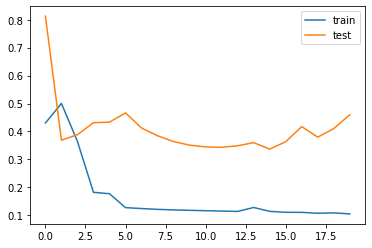

In [28]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

## Predictions

In [29]:
y_pred = model.predict(X_test)

In [30]:
y_train_inv = internet_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = internet_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = internet_transformer.inverse_transform(y_pred)

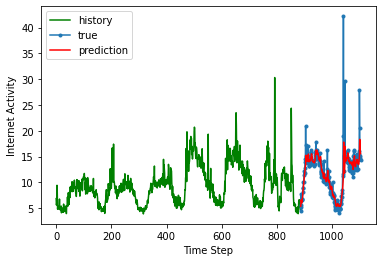

In [31]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

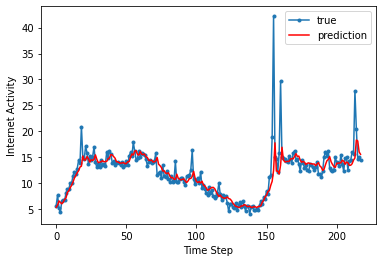

In [32]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Internet Activity')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [33]:
rmse = sqrt(mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten()))
print(rmse)

2.859434259136989


## Save data to folder

In [34]:
# PREDICTIONS

# Convert predictions to numpy array
arr = np.array(y_pred_inv.flatten())

# Change name to describe experiment: SPATIOLSTM2_<data_length[100,50,12]>_<grid_x>_<grid_y>_<num_values>
# ----------------------------------------
filename = "SPATIOLSTM2_12_70_10_81.npy"
# ----------------------------------------

folder_name = "../results/SPATIOLSTM2/predictions"
f = os.path.join(folder_name, filename)
np.save(f, arr)

# MODEL HISTORY

# Change name to describe experiment: SPATIOLSTM2_HISTORY_<data_length[100,50,12]>_<grid_x>_<grid_y>_<num_values>
# ----------------------------------------
filename = "SPATIOLSTM2_HISTORY_12_70_10_81.npy"
# ----------------------------------------

folder_name = "../results/SPATIOLSTM2/training"
f = os.path.join(folder_name, filename)
np.save(f,history.history)